# Scikit-learn

---
Student:<br>
Đinh Vũ Gia Hân - 22127098<br>
Đỗ Lê Khoa - 22127195

## Import libraries

In [1]:
import time
import joblib
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (log_loss, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score)

## Load data

The first step is to load the preprocessed data.

In [2]:
with open('../data/preprocessed_data.pkl', 'rb') as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

Because `MLPClassifier` utilizes one-hot encoded labels internally, we convert them to numerical values.

In [3]:
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
y_test = np.argmax(y_test, axis=1)

## Design model

We will construct the model with the following architecture:
- Hidden Layers: Two layers with 256 and 128 neurons, respectively.
- Activation Function: ReLU (Rectified Linear Unit).
- Optimizer: Adam.
- Batch Size: 128.
- Learning Rate: Initial value of 0.001, decreasing by 0.1% every 10 epochs.
- Maximum Iterations: 200.
- Early Stopping: Stop training if the loss does not improve within 10 epochs.

Since Scikit-learn does not natively support decreasing the learning rate, we must implement it manually. This also necessitates manual implementation of early stopping. Therefore, we will evaluate the model's performance every 10 epochs.

In [4]:
initial_lr = 0.001              # Initial learning rate
patience = 10                   # Maximum number of epochs allowed for non-improvement
min_delta = 0.001               # Minimum change in the monitored quantity to qualify as an improvement
best_val_loss = np.inf          # Best validation loss
best_val_score = 0              # Best validation score
epochs_no_improve = 0           # Count epochs with no improvement
max_epoch = 200                 # Maximum number of epochs
decay_epochs = 10               # Number of epochs after which learning rate decays
# model_path = "best_model.pkl"   # Path to save the best model

# Initialize MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(256, 128),  # 2 hidden layers
                    activation='relu',                # Activation function
                    solver='adam',                    # Optimizer
                    batch_size=128,                   # Batch size
                    learning_rate_init=initial_lr,    # Learning rate
                    max_iter=1,                       # Max epochs
                    warm_start=True,                  # Reuse previous fit
                    random_state=42)                  # Stable results

## Selecting Loss Function and Optimizer

We will utilize cross-entropy loss, the default in Scikit-learn, and the Adam optimizer (as stated above).

## Model Training

In [5]:
train_losses = []       # Training losses
val_losses = []         # Validation losses
val_accuracies = []     # Validation accuracies

# Mark the start time
start_time = time.time()

# Train model
for epoch in range(0, max_epoch):
    # Set learning rate
    model.set_params(learning_rate_init=initial_lr)

    # Train model
    model.fit(X_train, y_train)

    # Evaluate model
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    val_loss = log_loss(y_val, model.predict_proba(X_val))
    val_accuracy = accuracy_score(y_val, model.predict(X_val)) * 100

    # Log the metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print the results
    print(f"Epoch {epoch + 1}/{max_epoch}, Train Loss: {train_loss:.4f}, "
        f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Save the best model
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # joblib.dump(model, model_path)
        print("Validation loss improved. Saving model...")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

    # If the model has not improved for 'patience' epochs
    if epochs_no_improve >= patience:
        print("Early stopping...")
        break

    # Decay learning rate
    if (epoch + 10) % decay_epochs == 0:
        initial_lr *= 0.1

# Mark the end time
end_time = time.time()

Epoch 1/200, Train Loss: 1.7504, Validation Loss: 1.7841, Validation Accuracy: 35.96%
Validation loss improved. Saving model...
Epoch 2/200, Train Loss: 1.6826, Validation Loss: 1.7186, Validation Accuracy: 39.57%
Validation loss improved. Saving model...
Epoch 3/200, Train Loss: 1.6520, Validation Loss: 1.6914, Validation Accuracy: 40.47%
Validation loss improved. Saving model...
Epoch 4/200, Train Loss: 1.6279, Validation Loss: 1.6715, Validation Accuracy: 40.86%
Validation loss improved. Saving model...
Epoch 5/200, Train Loss: 1.6080, Validation Loss: 1.6547, Validation Accuracy: 41.43%
Validation loss improved. Saving model...
Epoch 6/200, Train Loss: 1.5905, Validation Loss: 1.6409, Validation Accuracy: 42.00%
Validation loss improved. Saving model...
Epoch 7/200, Train Loss: 1.5758, Validation Loss: 1.6298, Validation Accuracy: 42.49%
Validation loss improved. Saving model...
Epoch 8/200, Train Loss: 1.5598, Validation Loss: 1.6172, Validation Accuracy: 43.02%
Validation loss im

In [6]:
# Calculate the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Training time: 179.58 seconds


## Model Evaluation

Accuracy: 0.4613
Precision: 0.4550
Recall: 0.4613
F1: 0.4558


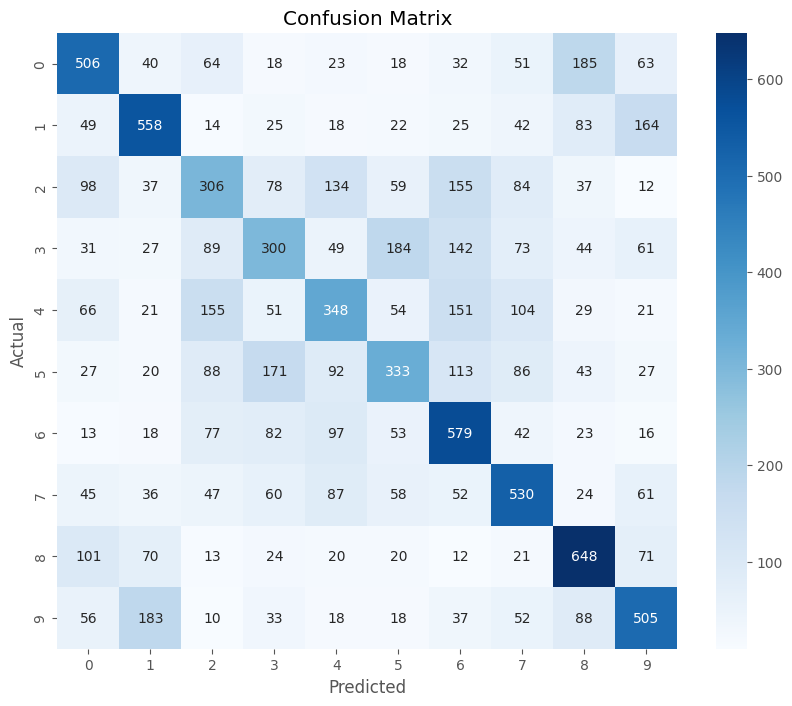

In [7]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Futher Usage

In [8]:
# Save the model
joblib.dump(model, 'sklearn_model.pkl')

# Load the model
model = joblib.load('sklearn_model.pkl')

Text(0.5, 1.0, 'Predicted: 3 - Actual: 3')

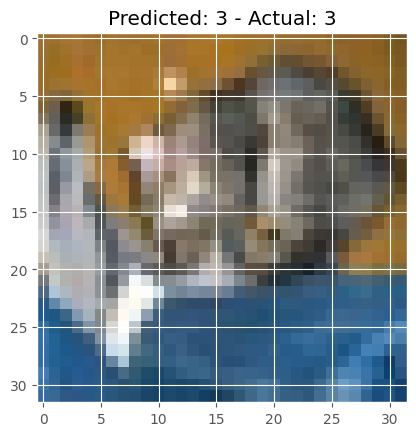

In [9]:
single_image = X_test[0]  # fist image in test
output = model.predict([single_image])
plt.imshow(single_image.reshape(32, 32, 3), cmap='gray')
plt.title(f'Predicted: {output[0]} - Actual: {y_test[0]}')